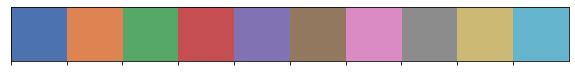

In [1]:
%matplotlib inline

import lsqfit
from alternative_ICs import *
from alternative_ICs.test_tmin import test_vary_tmin_SE

from alternative_ICs.stats import model_avg

In [2]:
p0_test_ME = {
    'A0': 2.0,
    'E0': 0.8,
    'A1': 10.4,
    'E1': 1.16,
}
Nt = 32

def ME_model(x,p):
    return multi_exp_model_lsqfit(x,p,Nexc=2)

# noise_params for Figures 3 and 5A
# noise_params = {
#     'frac_noise_amp': 0.3,
#     'noise_floor_amp': 0.0,
#     'noise_samples': 30,
# }

## noise_params for Figures 4 and 5B
noise_params = {
    'frac_noise_amp': 3E-3,
    'noise_floor_amp': 1E-5,
    'noise_samples': 200,
}

obs_name='E0'

correlated_data = True
rho = 0.6

In [3]:
# Set seed for consistency of outcome
np.random.seed(77700)  # Fig 3A or 4A
# np.random.seed(81890)  # Fig 3B or 4B
# np.random.seed(87414)  # Fig 3C or 4C
# np.random.seed(92787)  # Fig 3D or 4D

if correlated_data:
    test_data = gen_synth_data_corr(
        np.arange(0,Nt), 
        p0_test_ME, 
        ME_model,
        rho=rho,
        **noise_params)
else:
    test_data = gen_synth_data(
        np.arange(0,Nt), 
        p0_test_ME, 
        ME_model,
        **noise_params)

In [4]:
tmax = test_data['t'][-1]
max_tmin = tmax - 4


IC_list = ['BAIC', 'BPIC', 'PPIC']
test_res = test_vary_tmin_SE(test_data, Nt=Nt, tmax=tmax, max_tmin=max_tmin, obs_name=obs_name,
                             priors_SE={"A0": gv.gvar("0(10)"),"E0": gv.gvar("1(1)")}, full_BC=False,
                             IC_list=IC_list, data_snr_min=0.0)


for IC in IC_list:
    print(IC + f": E_0 = {test_res['obs_avg_IC'][IC]}")

BAIC: E_0 = 0.78(15)
BPIC: E_0 = 0.78(15)
PPIC: E_0 = 0.807(72)


/home/jsitison/model_averaging/alternative-ICs/alternative_ICs/plotting.py:220: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(test_res[x_coordn], p_norm[IC] / p_norm[IC_list[0]], color=IC_color[IC], linestyle=IC_linestyle[IC], label='pr$(M|D)$ ('+IC+')/pr$(M|D)$ ('+IC_list[0]+')')
/home/jsitison/model_averaging/alternative-ICs/alternative_ICs/plotting.py:220: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(test_res[x_coordn], p_norm[IC] / p_norm[IC_list[0]], color=IC_color[IC], linestyle=IC_linestyle[IC], label='pr$(M|D)$ ('+IC+')/pr$(M|D)$ ('+IC_list[0]+')')


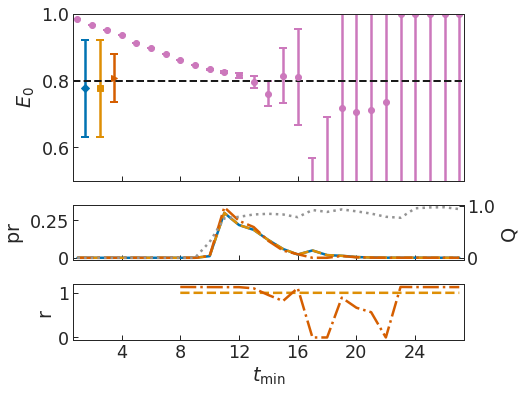

In [5]:
## Figure 3 or 4

# plot_MA_result(test_res, IC_list=IC_list, is_linear=False, target_value=p0_test_ME[obs_name],
#                show_IC_ratios=False, indv_plot_key='indv', ylim=[0.788,0.812])  # Fig 3
plot_MA_result(test_res, IC_list=IC_list, is_linear=False, target_value=p0_test_ME[obs_name],
               show_IC_ratios=True, indv_plot_key='indv', ylim=[0.5,1.0])  # Fig 4

## Uncomment to save figure to disk
# plt.savefig('plots/exp/fixed_N_no_floor_1.pdf', bbox_inches = "tight")  # Fig 3A
# plt.savefig('plots/exp/fixed_N_no_floor_2.pdf', bbox_inches = "tight")  # Fig 3B
# plt.savefig('plots/exp/fixed_N_no_floor_3.pdf', bbox_inches = "tight")  # Fig 3C
# plt.savefig('plots/exp/fixed_N_no_floor_4.pdf', bbox_inches = "tight")  # Fig 3D
# plt.savefig('plots/exp/fixed_N_floor_1.pdf', bbox_inches = "tight")  # Fig 4A
# plt.savefig('plots/exp/fixed_N_floor_2.pdf', bbox_inches = "tight")  # Fig 4B
# plt.savefig('plots/exp/fixed_N_floor_3.pdf', bbox_inches = "tight")  # Fig 4C
# plt.savefig('plots/exp/fixed_N_floor_4.pdf', bbox_inches = "tight")  # Fig 4D

In [6]:
## Scaling w/ number of samples

Nsamp_array = np.array([40, 80, 160, 320, 640, 1280])
Nsamp_max = Nsamp_array[-1]

np.random.seed(77700)  # Fig 5A and 5B

noise_params['noise_samples'] = Nsamp_max
if correlated_data:
    scale_data = gen_synth_data_corr(
        np.arange(0,Nt), 
        p0_test_ME, 
        ME_model,
        rho=rho,
        **noise_params)    
else:
    scale_data = gen_synth_data(
        np.arange(0,Nt),                              
        p0_test_ME, 
        ME_model,
        **noise_params)
    
IC_list = ['BAIC', 'BPIC', 'PPIC']
fixed_list = []
fixed_tmin = {}

obs_est_vs_Nsamp={}
for est in IC_list + fixed_list:
    obs_est_vs_Nsamp.update({est: []})


for Nsamp in Nsamp_array:
    test_data_scale = cut_synth_data_Nsamp(scale_data, Nsamp)
    test_res_scale = test_vary_tmin_SE(test_data_scale, Nt=Nt, max_tmin=Nt-4, obs_name=obs_name,
                                       priors_SE={"A0": gv.gvar("0(10)"),"E0": gv.gvar("1(1)")},
                                       IC_list=IC_list)
    
    for IC in IC_list:
        obs_est_vs_Nsamp[IC].append(test_res_scale['obs_avg_IC'][IC])
    for fixed in fixed_list:
        obs_est_vs_Nsamp[fixed].append(test_res_scale['obs'][fixed_tmin[fixed]])

<AxesSubplot:xlabel='$\\log(N)$', ylabel='$E_0$'>

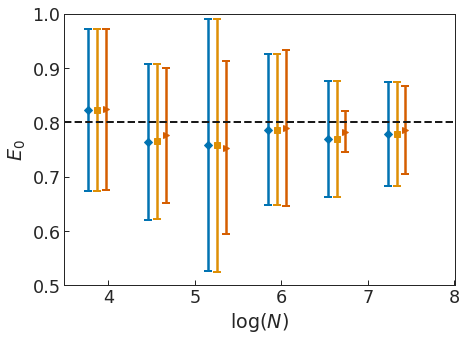

In [7]:
## Figure 5A or 5B

# plot_MA_result_scaling(obs_est_vs_Nsamp, Nsamp_array, IC_list=IC_list, is_linear=False,
#                        fixed_list=fixed_list, target_value=p0_test_ME[obs_name], indv_plot_key='indv',
#                        ylim=[0.788,0.812])  # Fig 5A
plot_MA_result_scaling(obs_est_vs_Nsamp, Nsamp_array, IC_list=IC_list, is_linear=False,
                       fixed_list=fixed_list, target_value=p0_test_ME[obs_name], indv_plot_key='indv',
                       ylim=[0.5,1.0])  # Fig 5B

# Uncomment to save figure to disk
# plt.savefig('plots/exp/N_scaling_no_floor.pdf', bbox_inches = "tight")  # Fig 5A
# plt.savefig('plots/exp/N_scaling_floor.pdf', bbox_inches = "tight")  # Fig 5B

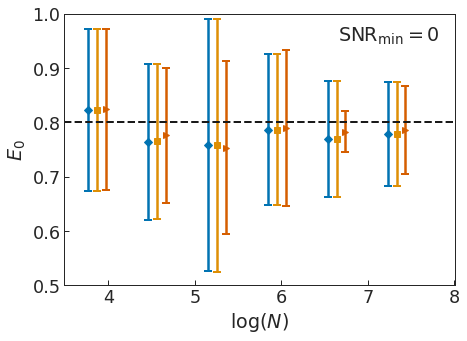

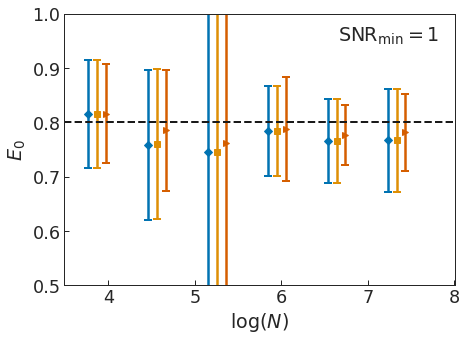

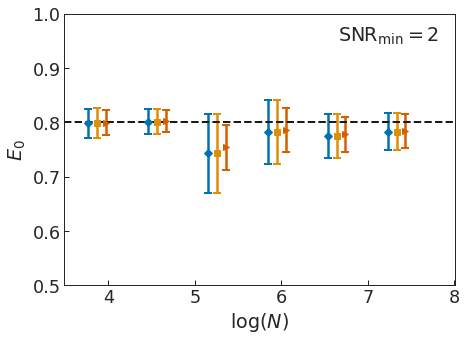

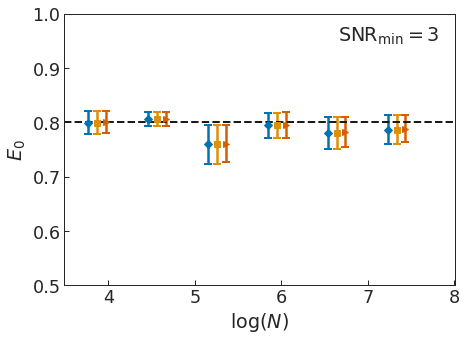

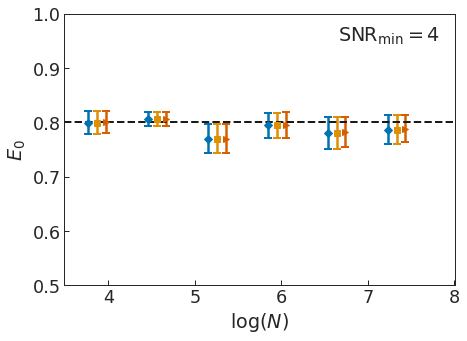

In [9]:
## Scaling w/ number of samples for different signal-to noise ratios

snr_array = np.array([0.0, 1.0, 2.0, 3.0, 4.0])

IC_list = ['BAIC', 'BPIC', 'PPIC']
fixed_list = []
fixed_tmin = {}

for snr in snr_array:
    Nsamp_array = np.array([40, 80, 160, 320, 640, 1280])
    Nsamp_max = Nsamp_array[-1]

    np.random.seed(77700)  # Fig 6

    noise_params['noise_samples'] = Nsamp_max
    if correlated_data:
        snr_data = gen_synth_data_corr(
            np.arange(0,Nt), 
            p0_test_ME, 
            ME_model,
            rho=rho,
            **noise_params)    
    else:
        snr_data = gen_synth_data(
            np.arange(0,Nt), 
            p0_test_ME, 
            ME_model,
            **noise_params)

    obs_est_vs_Nsamp={}
    for est in IC_list + fixed_list:
        obs_est_vs_Nsamp.update({est: []})


    for Nsamp in Nsamp_array:
        test_data_snr = cut_synth_data_Nsamp(snr_data, Nsamp)
        test_res_snr = test_vary_tmin_SE(test_data_snr, Nt=Nt, max_tmin=Nt-4, obs_name=obs_name,
                                         priors_SE={"A0": gv.gvar("0(10)"),"E0": gv.gvar("1(1)")},
                                         IC_list=IC_list, data_snr_min=snr)

        for IC in IC_list:
            obs_est_vs_Nsamp[IC].append(test_res_snr['obs_avg_IC'][IC])
        for fixed in fixed_list:
            obs_est_vs_Nsamp[fixed].append(test_res_snr['obs'][fixed_tmin[fixed]])


    ## Figure 6

    ax = plot_MA_result_scaling(obs_est_vs_Nsamp, Nsamp_array, IC_list=IC_list, is_linear=False, fixed_list=fixed_list, target_value=p0_test_ME[obs_name], indv_plot_key='indv', ylim=[0.5,1.0])
    plt.text(0.7, 0.9, r'${\rm SNR}_{\rm min} = $' + str(int(snr)), transform=ax.transAxes)
#     plt.show()
    
    ## Uncomment to save figure to disk
#     plt.savefig('plots/exp/N_scaling_SNR_'+str(int(snr))+'.pdf', bbox_inches = "tight")  # Fig 6

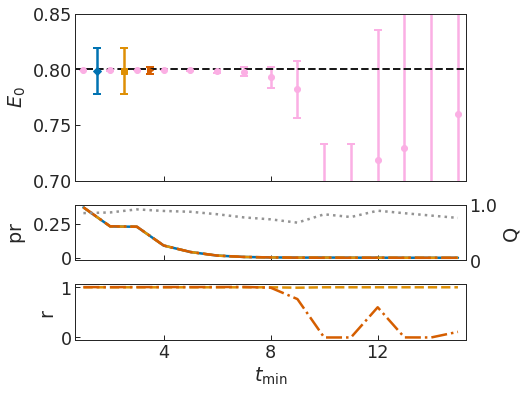

In [10]:
## Scaling w/ number of samples w/ two-state fit

Nsamp_array = np.array([40, 80, 160, 320, 640, 1280])
Nsamp_max = Nsamp_array[-1]

np.random.seed(77700)  # Fig 7 and 8

noise_params['noise_samples'] = Nsamp_max
noise_params['noise_floor_amp'] = 1E-5
if correlated_data:
    scale_data_2state = gen_synth_data_corr(
        np.arange(0,Nt), 
        p0_test_ME, 
        ME_model,
        rho=rho,
        **noise_params)    
else:
    scale_data_2state = gen_synth_data(
        np.arange(0,Nt), 
        p0_test_ME, 
        ME_model,
        **noise_params)

double_exp_fit = True

if double_exp_fit:
    priors_SE={"A0": gv.gvar("0(10)"),
           "E0": gv.gvar("1.5(1.0)"),
           'A1': gv.gvar("0(100)"),
           'ldE1': gv.gvar("-1(3)"),
          }
else:    
    priors_SE={"A0": gv.gvar("0(10)"),
               "E0": gv.gvar("0.8(1.0)"),
              }
    
IC_list = ['BAIC', 'BPIC', 'PPIC']
fixed_list = []
fixed_tmin = {}

obs_est_vs_Nsamp={}
for est in IC_list + fixed_list:
    obs_est_vs_Nsamp.update({est: []})


for Nsamp in Nsamp_array:
    test_data_scale_2state = cut_synth_data_Nsamp(scale_data_2state, Nsamp)
    test_res_scale_2state = test_vary_tmin_SE(test_data_scale_2state, Nt=Nt, max_tmin=Nt-4, obs_name=obs_name,
                                              IC_list=IC_list, data_snr_min=4.0, double_exp_fit=double_exp_fit,
                                              priors_SE=priors_SE)
    
    for IC in IC_list:
        obs_est_vs_Nsamp[IC].append(test_res_scale_2state['obs_avg_IC'][IC])
    for fixed in fixed_list:
        obs_est_vs_Nsamp[fixed].append(test_res_scale_2state['obs'][fixed_tmin[fixed]])

        
    ## Figure 7
    if Nsamp==640:
        plot_MA_result(test_res_scale_2state, IC_list=IC_list, is_linear=False, target_value=p0_test_ME[obs_name],
                       show_IC_ratios=True, indv_plot_key='indv_2state', ylim=[0.7,0.85])

        ## Uncomment to save figure to disk
#         plt.savefig('plots/exp/fixed_N_2state_'+str(int(Nsamp))+'.pdf', bbox_inches = "tight")  # Fig 7

Text(0.5, 0.9, '2-state, ${\\rm SNR}_{\\rm min} = $4')

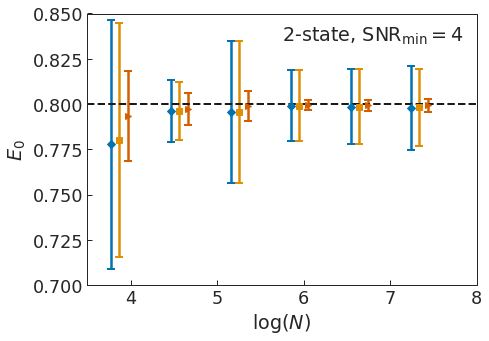

In [11]:
## Figure 8

ax = plot_MA_result_scaling(obs_est_vs_Nsamp, Nsamp_array, IC_list=IC_list, is_linear=False, fixed_list=fixed_list, target_value=p0_test_ME[obs_name], indv_plot_key='indv_2state', ylim=[0.7,0.85])
plt.text(0.5, 0.9, r'2-state, ${\rm SNR}_{\rm min} = $' + str(int(snr)), transform=ax.transAxes)

# Uncomment to save figure to disk
# plt.savefig('plots/exp/N_scaling_2state.pdf', bbox_inches = "tight")

In [11]:
## Scaling w/ number of samples - grand average

Nsamp_array = np.array([40, 80, 160, 320, 640, 1280])
Nsamp_max = Nsamp_array[-1]

# np.random.seed(93897)  # Fig 9
np.random.seed(77700)

noise_params['noise_samples'] = Nsamp_max
if correlated_data:
    scale_data = gen_synth_data_corr(
        np.arange(0,Nt), 
        p0_test_ME, 
        ME_model,
        rho=rho,
        **noise_params)    
else:
    scale_data = gen_synth_data(
        np.arange(0,Nt), 
        p0_test_ME, 
        ME_model,
        **noise_params)

priors_SE_1state={"A0": gv.gvar("0(10)"),
                  "E0": gv.gvar("0.8(1)")}
priors_SE_2state={"A0": gv.gvar("0(10)"),
                  "E0": gv.gvar("0.8(1)"),
                  'A1': gv.gvar("3(100000)e-4"),
                  'ldE1': gv.gvar("-1(3)")}
    
IC_list = ['BAIC', 'BPIC', 'PPIC']
fixed_list = []
fixed_tmin = {}

obs_est_vs_Nsamp_ga={}
for est in IC_list + fixed_list:
    obs_est_vs_Nsamp_ga.update({est: []})

for Nsamp in Nsamp_array:
    test_data_scale = cut_synth_data_Nsamp(scale_data, Nsamp)
    test_res_scale_1state = test_vary_tmin_SE(test_data_scale, Nt=Nt, max_tmin=Nt-4, obs_name=obs_name,
                                              IC_list=IC_list, data_snr_min=4.0, double_exp_fit=False,
                                              priors_SE=priors_SE_1state)
    test_res_scale_2state = test_vary_tmin_SE(test_data_scale, Nt=Nt, max_tmin=Nt-4, obs_name=obs_name,
                                              IC_list=IC_list, data_snr_min=4.0, double_exp_fit=True,
                                              priors_SE=priors_SE_2state)
    
    for IC in IC_list:
        ICs = np.concatenate((test_res_scale_1state['IC'][IC],test_res_scale_2state['IC'][IC]),axis=None)
        probs = np.exp(-(ICs-np.amin(ICs))/2)
        obs = np.concatenate((test_res_scale_1state['obs'],test_res_scale_2state['obs']),axis=None)
        
        obs_est_vs_Nsamp_ga[IC].append(model_avg(obs, probs))

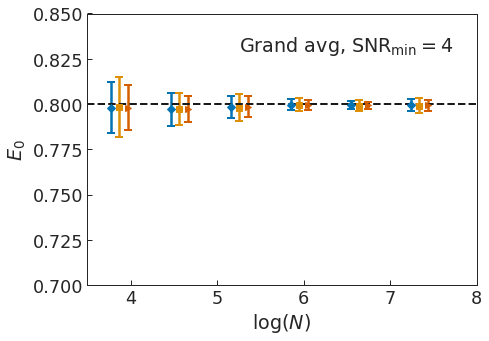

In [16]:
## Figure 9

plot_MA_result_scaling(obs_est_vs_Nsamp_ga, Nsamp_array, IC_list=IC_list, fixed_list=fixed_list, is_linear=False, target_value=p0_test_ME[obs_name], ylim=[0.7,0.85])
plt.text(0.45, 0.9, r'Grand avg, ${\rm SNR}_{\rm min} = $' + str(int(snr)), transform=ax.transAxes)

# Uncomment to save figure to disk
# plt.savefig('plots/exp/N_scaling_ga.pdf', bbox_inches = "tight")